In [2]:
import pandas as pd 
import seaborn as sns
import plotly.express as px
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import io
%matplotlib inline
plt.style.use('ggplot')

In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/lutsuk/lutsuk/main/olist_customers_dataset.csv")

In [4]:
df2 = pd.read_csv("https://raw.githubusercontent.com/lutsuk/lutsuk/main/olist_order_items_dataset.csv")

In [5]:
df3 = pd.read_csv("https://raw.githubusercontent.com/lutsuk/lutsuk/main/olist_orders_dataset.csv")

In [6]:
df1[:3]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [7]:
df2[:3]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [8]:
df3[:3]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [9]:
#Поменяем тип данных
df2.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [40]:
df2.count()

order_id               112650
order_item_id          112650
product_id             112650
seller_id              112650
shipping_limit_date    112650
price                  112650
freight_value          112650
dtype: int64

In [47]:
df2.order_id.nunique()

98666

In [10]:
df2.shipping_limit_date = pd.to_datetime(df2.shipping_limit_date)

In [11]:
df3.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [12]:
df3.order_delivered_customer_date = pd.to_datetime(df3.order_delivered_customer_date)
df3.order_delivered_carrier_date = pd.to_datetime(df3.order_delivered_carrier_date)
df3.order_estimated_delivery_date = pd.to_datetime(df3.order_estimated_delivery_date)

In [13]:
# customer_id является уникальным в df1 и df3
print(df1.customer_id.nunique() - df1.customer_id.count())
print(df3.customer_id.nunique() - df3.customer_id.count())

0
0


In [14]:
#join df
df =  df1.merge(df3, how='left', on='customer_id')

In [15]:
df[:3]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13


In [16]:
# одну покупку совершило 90549 уникальных пользователей
one_purchase = df[(df.order_delivered_customer_date.notnull() == True) & \
                       (df.order_status == "delivered")]\
                        .groupby('customer_unique_id', as_index=False)\
                        .agg({'order_id' : 'count'})
print(one_purchase[one_purchase.order_id == 1].customer_unique_id.count())

90549


In [17]:
df.order_status.unique()

array(['delivered', 'canceled', 'invoiced', 'shipped', 'processing',
       'unavailable', 'approved', 'created'], dtype=object)

In [18]:
    # Исходя из статусов заказа можно сказать, что мы имеем 2 статуса где товар без доставки:
        # "Отмена" и "заказ недоступен". 

In [19]:
non_delivery = df.query("(order_status == 'unavailable') | (order_status == 'canceled')")\
                       .groupby('order_status', as_index=False)\
                       .agg({'order_id' : 'count'})\
                       .rename(columns = {'order_id' : 'count_orders'})
non_delivery

,order_status,count_orders
0,canceled,625
1,unavailable,609


In [20]:
df.order_delivered_customer_date = df.order_delivered_customer_date.fillna("invalid_date")

In [21]:
#Посмотрим тренд MoM по объему заказов у разных штатов

In [22]:
#удалим товары без доставки
df = df.query('order_delivered_customer_date != "invalid_date"')

In [23]:
df['year_month'] = df.order_delivered_customer_date.apply(lambda x : x.strftime('%Y-%m'))

In [24]:
#посчитаем заказы по штату и периоду
test = df.query("order_status == 'delivered'")\
         .groupby(['year_month','customer_state'])\
         .agg({'order_id' : pd.Series.nunique})\
         .sort_values(['customer_state', 'year_month'] , ascending=True)\
         .reset_index()

In [25]:
#найдем месяц первого заказа в штате
min_month = df.query("order_status == 'delivered'")\
         .groupby(['customer_state'])\
         .agg({'year_month' : 'min'})\
         .rename(columns = {'year_month' : 'min_month'})\
         .reset_index()

In [26]:
#совместим данные
test = test.merge(min_month, how='left', on = 'customer_state', right_index=False)
test.rename(columns={'year_month_x' : 'year_month'}, inplace=True)

In [27]:
test[:4]

,year_month,customer_state,order_id,min_month
0,2017-02,AC,2,2017-02
1,2017-03,AC,5,2017-02
2,2017-05,AC,9,2017-02
3,2017-06,AC,5,2017-02


In [28]:
#добавим данные по месяцу "до" для рассчета MoM
test['lag'] = test.order_id.shift(1)

In [29]:
#нужно чтобы в lag были данные только из одного штата, строчка с мин датой должна быть пустой у всех штатов
test['lag'] = pd.DataFrame.where(cond=(test.year_month != test.min_month), self=test.lag, other=np.nan)

In [30]:
test['MoM'] = (test.order_id / test.lag) - 1

In [31]:
test[:4]

,year_month,customer_state,order_id,min_month,lag,MoM
0,2017-02,AC,2,2017-02,NaN,NaN
1,2017-03,AC,5,2017-02,2.0,1.500000
2,2017-05,AC,9,2017-02,5.0,0.800000
3,2017-06,AC,5,2017-02,9.0,-0.444444


In [32]:
#можно убрать пустые значения
test = test[test.isna().lag == False]

In [33]:
#отберем топ 5 штатов по заказам
top_5 = test.groupby('customer_state', as_index=False).agg({'order_id': 'sum'})\
            .sort_values('order_id', ascending=False).customer_state[:5]

In [34]:
l = [i for i in top_5]

In [35]:
data_top_5 = test.query('customer_state in @l')

In [36]:
data_top_5[:5]

,year_month,customer_state,order_id,min_month,lag,MoM
212,2016-11,MG,6,2016-10,29.0,-0.793103
213,2017-01,MG,43,2016-10,6.0,6.166667
214,2017-02,MG,192,2016-10,43.0,3.465116
215,2017-03,MG,329,2016-10,192.0,0.713542
216,2017-04,MG,252,2016-10,329.0,-0.234043


In [68]:
#Подготовим RFM анализ

In [37]:
# Подготовим данные по доставленным заказам
df_for_rfm = df[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [48]:
# Агрегируем данные по заказам 
# Один товар может повторяться в заказе отдельной строчкой с другим идентификатором товара
orders = df2.groupby(['order_id'], as_index=False).agg({'price' : 'sum'})

In [49]:
# Добавим эти данные к информации о доставленных заказах
rfm = df_for_rfm.merge(orders, on = 'order_id', how='left')
rfm.order_purchase_timestamp = pd.to_datetime(rfm.order_purchase_timestamp)

In [50]:
# Добавим дату последней покупки
max_date = df.groupby('customer_unique_id', as_index=False)\
           .agg({'order_purchase_timestamp' : 'max'})\
           .rename(columns={'order_purchase_timestamp':'max_date'})
rfm = rfm.merge(max_date[['customer_unique_id','max_date']], on='customer_unique_id', how='left')

In [56]:
rfm.max_date = pd.to_datetime(rfm.max_date)

In [57]:
# рассчитаем Recency = количество дней с момента последней покупки
rfm['day_diff'] = rfm.max_date.apply(lambda x: (pd.to_datetime(pd.Timestamp.now()) - x).days)

In [58]:
# рассчитаем частоту = суммарное количество покупок у пользователя за всё время
# рассчитаем сумму покупок пользователя за всё время
# и в количестве дней с момента последней покупки возмьем минимальную разницу в днях c последней полкупки
rfm = rfm.groupby('customer_unique_id',as_index=False)\
           .agg({'day_diff' : 'min', 'price' : 'sum', 'order_id' : pd.Series.nunique})\
           .rename(columns = {'day_diff' : 'Recency', 'price' : 'Monetary', 'order_id' : 'Frequency'})

In [59]:
# Каждый клиент получит оценку от 1 до 5 для каждого параметра.
# Используем квинтили за сигментирования, каждый квинтил содержит 20% данных. 
# Использование квинтиля является более гибким, так как диапазоны будут адаптироваться к данным 
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 1651.0, 0.4: 1736.0, 0.6: 1827.0, 0.8: 1942.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [60]:
# Добавим функцию для сигментирования в зависимости от значений
# Для Recency лучше меньшее значение, а для частоты и денег большее значение лучше. 
# По этой причине напишем два отдельных метода.
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [61]:
# Поставим оценки
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [62]:
# Получим итоговые значения 
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm[:5]

,customer_unique_id,Recency,Monetary,Frequency,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,1671,129.90,1,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1674,18.90,1,4,1,1,411
2,0000f46a3911fa3c0805444483337064,2096,69.00,1,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,1880,25.99,1,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,1848,180.00,1,2,1,5,215


In [63]:
# У нас очень низкие показатели Recency и Frequency у клиентов, так что при делении на группы сделаем акцент на них. 
# Особенно на время с последней покупки пользователя для привлечения новых лояльных клиентов и удержания имеющихся.

# Т.к анализируются старые данные, то дни с последней покупки сильно завышены, но мы будем считать, что с ними все хорошо. 

In [64]:
segt_map = {
    r'1[1-2][1-2]': 'Полная спячка', 
    r'1[1-5][1-5]': 'Потенциально лояльные в спячке', 
    r'2[1-5][1-5]': 'Потенциально лояльные',
    r'3[1-5][1-5]': 'Лояльные', 
    r'4[1-5][1-5]': 'Лояльные', 
    r'5[1-3][1-5]': 'Лояльные', 
    r'5[1-5][1-3]': 'Лояльные', 
    r'5[4-5][4-5]': 'Сильные лояльные' 
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.Segment.unique()

array(['Лояльные', 'Полная спячка', 'Потенциально лояльные',
       'Потенциально лояльные в спячке', 'Сильные лояльные'], dtype=object)

In [65]:
rfm[:5]

,customer_unique_id,Recency,Monetary,Frequency,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1671,129.90,1,4,1,4,414,Лояльные
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1674,18.90,1,4,1,1,411,Лояльные
2,0000f46a3911fa3c0805444483337064,2096,69.00,1,1,1,2,112,Полная спячка
3,0000f6ccb0745a6a4b88665a16c9f078,1880,25.99,1,2,1,1,211,Потенциально лояльные
4,0004aac84e0df4da2b147fca70cf8255,1848,180.00,1,2,1,5,215,Потенциально лояльные


In [66]:
rfm.groupby('Segment', as_index=False)\
               .agg({'customer_unique_id':'count'
                     , 'Recency' : ['max','min']
                     , 'Monetary' : ['max','min']
                     ,'Frequency' : ['max','min']})\
               .rename(columns={'customer_unique_id':'Segment_size'})

Segment Segment_size Recency       Monetary          \
                                         count     max   min      max     min   
0                        Лояльные        55554    1827  1560   7160.0    0.85   
1                   Полная спячка         8016    2255  1943     69.9    3.90   
2           Потенциально лояльные        18733    1942  1828  13440.0    2.29   
3  Потенциально лояльные в спячке        10569    2273  1943   7388.0   20.70   
4                Сильные лояльные          484    1651  1561   4080.0  112.20   

  Frequency      
        max min  
0         9   1  
1         1   1  
2         4   1  
3         6   1  
4        15   2

<AxesSubplot:xlabel='Segment', ylabel='Segment_size'>

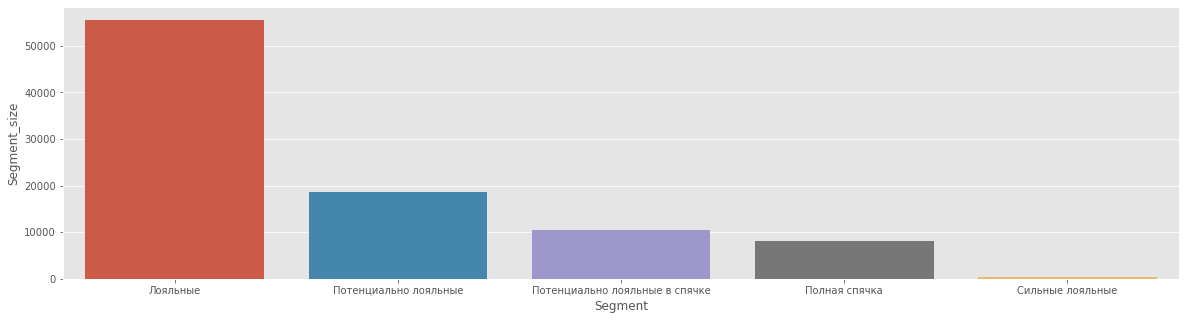

In [67]:
# Итого у нас большая группа лояльных клиентов - группа с показателем Recency выше среднего
# На втором месте потенциально лояльные  - группа с которой можно поработать, пока время с послед. покупки 
# не стало еще меньше 
# Потенциально лояльные в спячке - низкое время с последней покупки, но имеются высокие показатели показатели
# Полная спячка - группа с самым низким RFM 
# Сильные лояльные - показатели выше среднего
plt.figure(figsize=(20,5))
sns.barplot(x = rfm.groupby('Segment', as_index=False)\
               .agg({'customer_unique_id':'count'})\
               .rename(columns={'customer_unique_id':'Segment_size'})\
               .sort_values('Segment_size', ascending=False).Segment,
            y = rfm.groupby('Segment', as_index=False)\
               .agg({'customer_unique_id':'count'})\
               .rename(columns={'customer_unique_id':'Segment_size'})\
               .sort_values('Segment_size', ascending=False).Segment_size)

                                        Таблица заказов
        1) order_id —  уникальный идентификатор заказа (номер чека)
        2) customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
        3) order_status —  статус заказа
        4) order_purchase_timestamp —  время создания заказа
        5) order_approved_at —  время подтверждения оплаты заказа
        6) order_delivered_carrier_date —  время передачи заказа в логистическую службу
        7) order_delivered_customer_date —  время доставки заказа
        8) order_estimated_delivery_date —  обещанная дата доставки

        Уникальные статусы заказов в таблице olist_orders_dataset:

        created —  создан
        approved —  подтверждён
        invoiced —  выставлен счёт
        processing —  в процессе сборки заказа
        shipped —  отгружен со склада
        delivered —  доставлен пользователю
        unavailable —  недоступен
        canceled —  отменён

                    Таблица с уникальными идентификаторами пользователей
        1) customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
        2) customer_unique_id —  уникальный идентификатор пользователя
        3) customer_zip_code_prefix —  почтовый индекс пользователя
        4) customer_city —  город доставки пользователя
        5) customer_state —  штат доставки пользователя

                            Товарные позиции, входящие в заказы
        1) order_id —  уникальный идентификатор заказа (номер чека)
        2) order_item_id —  идентификатор товара внутри одного заказа
        3) product_id —  ид товара (аналог штрихкода)
        4) seller_id — ид производителя товара
        5) shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
        6) price —  цена за единицу товара
        7) freight_value —  вес товара